Formula 1 (from https://www.nature.com/articles/nature07788) can be used to relate diffraction pattern intensity values to the material's scattering vector (s-value/reciprocal values), as well as it's uiso value (which is dependent on temperature). 

However, when using s-values given by CrystalMaker, the formula gives incorrect predictions for uiso. This notebook will apply a modified version of Formula 1 (which is rearranged to solve for s-values) to CrystalMaker data, and then attempt to find a relation between the s-values given by Crystal Maker and the calculated s-values.

In [51]:
#Mounting Drive
from google.colab import drive 
drive.mount('/content/drive')

#Imports
from google.colab import files
import os
import math
import matplotlib.pyplot as plt
import numpy as np


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
#Function which applies Formula 1 to CrystalMaker data
def intensity_formula(tuple_unexcited,tuple_excited):
  reciprocal_val_unexcited, intensity_unexcited, uiso_unexcited = tuple_unexcited 
  reciprocal_val_excited, intensity_excited, uiso_excited = tuple_excited

  try:
    s_val = math.sqrt((-2*math.log(intensity_excited/intensity_unexcited))/(uiso_excited-uiso_unexcited))
    return s_val
  except:
    #In case there are any math errors (such as dividing by zero), the function returns 'error'
    return 'error'


def retrieve_reciprocal_data(directory="/content/drive/MyDrive/Bismuth_Data_Processed/Bismuth profiles/Reciprocal Profiles"):
  #Opens diffraction profile files, and orders data in a dictionary 
  
  
  reciprocal_vals = [] #ordered list in which reciprocal values (s-values calculated by CrystalMaker will be stored)
  intermediate_list = [] #list of [reciprocal val, intensity, uiso] values 
  
  #Opening diffraction files
  for subdirectories, directories, files in os.walk("/content/drive/MyDrive/Bismuth_Data_Processed/Bismuth profiles/Reciprocal Profiles"):
    for file_name in files:      
      file = open(subdirectories + os.path.sep + file_name, "r")
      uiso_val = float(file_name.split("reciprocal_")[1].split(".txt")[0])      
      
      for line in file:
        data_point = line.split() #X and Y values are separated by a space
        
        #converting data to float values
        reciprocal_val=float(data_point[0])
        intensity_val = float(data_point[1])
        
        #appending [reciprocal val, intensity, uiso] to an intermediate list for further processing
        intermediate_list.append([reciprocal_val,intensity_val,uiso_val])
        if reciprocal_val not in reciprocal_vals:
          reciprocal_vals.append(reciprocal_val)
          reciprocal_vals.sort()
        

  ordered_dict = dict() #initializing dictionary
  #Formula 1 is applied to data across various uiso values that has the same s-value, so data will be organized accordingly
  #organizing data in dictionary by s-value {'0.0':[[data tuple for uiso = 0],[data tuple for uiso = 1],[data tuple for uiso = 2]...],'0.1':....}
  
  for reciprocal_val in reciprocal_vals: #iterating through all reciprocal values
    like_points = []

    for element in intermediate_list: #iterating through all of the elements in the intermediate list to find which ones have a given reciprocal value
      if element[0] == reciprocal_val:
        like_points.append([reciprocal_val,element[1],element[2]])

    if len(like_points) > 1:
      ordered_dict[reciprocal_val] = like_points #this list of lists is stored in the dictionary, with the shared s-value used as the key
  return ordered_dict


ordered_dict = retrieve_reciprocal_data()
key_list = list(ordered_dict.keys())

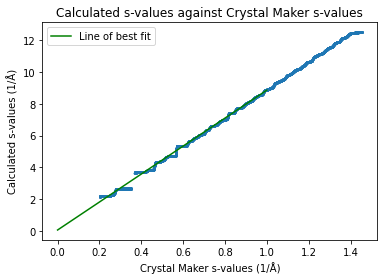

Line of best fit equation:  
8.789 x + 0.0696


In [62]:
key_list = list(ordered_dict.keys())
vals_to_plot = []

for key in key_list:
  vals_to_check = ordered_dict[key]
  for index in range(1,len(vals_to_check)):
    #Applying Formula 1 to all data points with the same s-value
    s_val = intensity_formula(vals_to_check[0],vals_to_check[index])
  if s_val is not 'error':
      vals_to_plot.append([key,s_val])

#Plotting calculated s-vales against CrystalMaker s-values
x,y = zip(*vals_to_plot)
plt.scatter(x,y,s=1)
plt.xlabel("Crystal Maker s-values (1/Å)")
plt.ylabel("Calculated s-values (1/Å)")
plt.title("Calculated s-values against Crystal Maker s-values")

#Determining + Plotting line of best fit
linear_model=np.polyfit(x,y,1)
linear_model_fn=np.poly1d(linear_model)
x_s=np.arange(0,1.5)
plt.plot(x_s,linear_model_fn(x_s),color="green",label="Line of best fit")
plt.legend()
plt.show()
print("Line of best fit equation: " + str(linear_model_fn))